In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import normaltest, levene, ttest_ind, chi2_contingency, pearsonr
import warnings
warnings.filterwarnings('ignore')

In [2]:
try:
    df_main = pd.read_csv('Data/processed/main_dataset_clean.csv')
    user_metrics = pd.read_csv('Data/processed/user_metrics_aggregated.csv')
    print("DataFrame fue cargado exitosamente.")
except FileNotFoundError:
    print("Error: El archivo no se encontró. Asegúrate de haberlo guardado en la carpeta correcta.")

DataFrame fue cargado exitosamente.


## Measures of Central Tendency and Dispersion


In [3]:
def calculate_descriptive_stats(df, columns, dataset_name):
    print(f"\nESTADÍSTICAS DESCRIPTIVAS - {dataset_name.upper()}")
    print("="*70)
    
    stats_results = {}
    
    for col in columns:
        if col in df.columns and df[col].dtype in ['int64', 'float64']:
            data = df[col].dropna()
            
            # Medidas de tendencia central
            mean_val = data.mean()
            median_val = data.median()
            mode_result = stats.mode(data, keepdims=True)
            mode_val = mode_result.mode[0] if len(mode_result.mode) > 0 else np.nan
            
            # Medidas de dispersión
            std_val = data.std()
            var_val = data.var()
            range_val = data.max() - data.min()
            iqr_val = data.quantile(0.75) - data.quantile(0.25)
            cv_val = (std_val / mean_val) * 100  # Coeficiente de variación
            
            # Percentiles
            p10 = data.quantile(0.10)
            p25 = data.quantile(0.25)
            p75 = data.quantile(0.75)
            p90 = data.quantile(0.90)
            
            # Medidas de forma
            skewness = stats.skew(data)
            kurtosis = stats.kurtosis(data)
            
            stats_results[col] = {
                'count': len(data),
                'mean': mean_val,
                'median': median_val,
                'mode': mode_val,
                'std': std_val,
                'variance': var_val,
                'range': range_val,
                'iqr': iqr_val,
                'cv_%': cv_val,
                'p10': p10,
                'p25': p25,
                'p75': p75,
                'p90': p90,
                'skewness': skewness,
                'kurtosis': kurtosis,
                'min': data.min(),
                'max': data.max()
            }
            
            print(f"\n {col.upper()}:")
            print(f"   Tendencia Central:")
            print(f"     • Media: {mean_val:.2f}")
            print(f"     • Mediana: {median_val:.2f}")
            print(f"     • Moda: {mode_val:.2f}")
            print(f"   Dispersión:")
            print(f"     • Desviación Estándar: {std_val:.2f}")
            print(f"     • Varianza: {var_val:.2f}")
            print(f"     • Rango: {range_val:.2f}")
            print(f"     • IQR: {iqr_val:.2f}")
            print(f"     • Coeficiente de Variación: {cv_val:.2f}%")
            print(f"   Percentiles:")
            print(f"     • P10: {p10:.2f} | P25: {p25:.2f} | P75: {p75:.2f} | P90: {p90:.2f}")
            print(f"   Forma de la Distribución:")
            print(f"     • Asimetría (Skewness): {skewness:.3f}")
            print(f"     • Curtosis: {kurtosis:.3f}")
    
    return pd.DataFrame(stats_results).T

# Calcular estadísticas para variables clave
key_variables = ['age', 'total_watch_time_hours', 'watch_duration_minutes', 
                'completion_percentage', 'total_sessions', 'avg_completion_rate']

# Estadísticas del dataset principal
main_vars = [col for col in ['watch_duration_minutes', 'completion_percentage'] if col in df_main.columns]
stats_main = calculate_descriptive_stats(df_main, main_vars, "Dataset Principal")

# Estadísticas de métricas de usuario
user_vars = [col for col in ['age', 'total_watch_time_hours', 'total_sessions', 'avg_completion_rate'] 
             if col in user_metrics.columns]
stats_user = calculate_descriptive_stats(user_metrics, user_vars, "Métricas de Usuario")



ESTADÍSTICAS DESCRIPTIVAS - DATASET PRINCIPAL

 WATCH_DURATION_MINUTES:
   Tendencia Central:
     • Media: 83.99
     • Mediana: 87.00
     • Moda: 104.00
   Dispersión:
     • Desviación Estándar: 44.02
     • Varianza: 1937.77
     • Rango: 178.00
     • IQR: 74.00
     • Coeficiente de Variación: 52.41%
   Percentiles:
     • P10: 25.00 | P25: 44.00 | P75: 118.00 | P90: 145.00
   Forma de la Distribución:
     • Asimetría (Skewness): 0.094
     • Curtosis: -1.059

 COMPLETION_PERCENTAGE:
   Tendencia Central:
     • Media: 78.40
     • Mediana: 84.50
     • Moda: 100.00
   Dispersión:
     • Desviación Estándar: 21.44
     • Varianza: 459.64
     • Rango: 90.00
     • IQR: 29.70
     • Coeficiente de Variación: 27.35%
   Percentiles:
     • P10: 50.20 | P25: 66.30 | P75: 96.00 | P90: 100.00
   Forma de la Distribución:
     • Asimetría (Skewness): -1.159
     • Curtosis: 0.755

ESTADÍSTICAS DESCRIPTIVAS - MÉTRICAS DE USUARIO

 AGE:
   Tendencia Central:
     • Media: 41.59
     • 

## Detección y Análisis de Outliers


In [4]:
def detect_outliers_comprehensive(df, column, methods=['iqr', 'zscore', 'modified_zscore']):
    data = df[column].dropna()
    outliers_info = {}
    
    # Método 1: IQR
    if 'iqr' in methods:
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        iqr_outliers = data[(data < lower_bound) | (data > upper_bound)]
        outliers_info['iqr'] = {
            'method': 'IQR (1.5 * IQR)',
            'lower_bound': lower_bound,
            'upper_bound': upper_bound,
            'outliers': iqr_outliers,
            'count': len(iqr_outliers),
            'percentage': (len(iqr_outliers) / len(data)) * 100
        }
    
    # Método 2: Z-Score
    if 'zscore' in methods:
        z_scores = np.abs(stats.zscore(data))
        zscore_outliers = data[z_scores > 3]
        outliers_info['zscore'] = {
            'method': 'Z-Score (|z| > 3)',
            'threshold': 3,
            'outliers': zscore_outliers,
            'count': len(zscore_outliers),
            'percentage': (len(zscore_outliers) / len(data)) * 100
        }
    
    # Método 3: Modified Z-Score (más robusto)
    if 'modified_zscore' in methods:
        median = np.median(data)
        mad = np.median(np.abs(data - median))
        modified_z_scores = 0.6745 * (data - median) / mad
        mod_zscore_outliers = data[np.abs(modified_z_scores) > 3.5]
        outliers_info['modified_zscore'] = {
            'method': 'Modified Z-Score (|mz| > 3.5)',
            'threshold': 3.5,
            'outliers': mod_zscore_outliers,
            'count': len(mod_zscore_outliers),
            'percentage': (len(mod_zscore_outliers) / len(data)) * 100
        }
    
    return outliers_info

In [5]:
def plot_outlier_analysis(df, columns, figsize=(16, 12)):
    n_cols = len(columns)

    fig, axes = plt.subplots(1, n_cols, figsize=figsize) 
    
    if n_cols == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    outlier_summary = []
    
    for i, col in enumerate(columns):
        if col in df.columns and i < len(axes):
            data = df[col].dropna()
            
            # Detectar outliers
            outliers_info = detect_outliers_comprehensive(df, col)
            
            ax = axes[i]
            
            # Boxplot
            box_plot = ax.boxplot(data, patch_artist=True, vert=True)
            box_plot['boxes'][0].set_facecolor('lightblue')
            box_plot['boxes'][0].set_alpha(0.7)
            
            # Añadir información de outliers
            iqr_info = outliers_info['iqr']
            ax.axhline(y=iqr_info['lower_bound'], color='red', linestyle='--', alpha=0.7, label='IQR Límites')
            ax.axhline(y=iqr_info['upper_bound'], color='red', linestyle='--', alpha=0.7)
            
            # Título con información
            ax.set_title(f'Outliers en {col}\n'
                        f'IQR: {iqr_info["count"]} ({iqr_info["percentage"]:.1f}%)\n'
                        f'Z-Score: {outliers_info["zscore"]["count"]} ({outliers_info["zscore"]["percentage"]:.1f}%)',
                        fontweight='bold', fontsize=10)
            ax.set_ylabel(col)
            ax.set_xticks([]) # Remover ticks del eje X
            ax.grid(True, alpha=0.3)
            
            outlier_summary.append({
                'Variable': col,
                'Total_Datos': len(data),
                'Outliers_IQR': iqr_info['count'],
                'Porcentaje_IQR': iqr_info['percentage'],
                'Outliers_ZScore': outliers_info['zscore']['count'],
                'Porcentaje_ZScore': outliers_info['zscore']['percentage'],
                'Limite_Inferior': iqr_info['lower_bound'],
                'Limite_Superior': iqr_info['upper_bound']
            })
        
    plt.tight_layout()
    plt.show()
    
    return pd.DataFrame(outlier_summary)

ANÁLISIS DE OUTLIERS


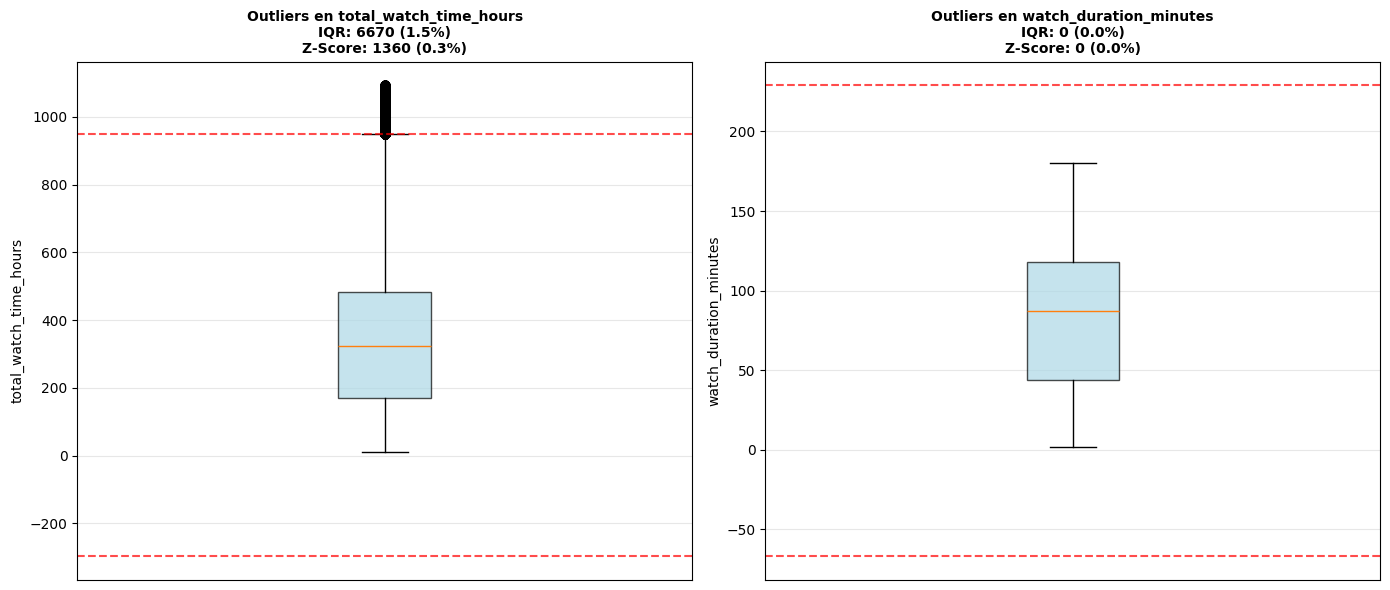


RESUMEN DE OUTLIERS - Dataset Principal:


,Variable,Total_Datos,Outliers_IQR,Porcentaje_IQR,Outliers_ZScore,Porcentaje_ZScore,Limite_Inferior,Limite_Superior
0,total_watch_time_hours,430688,6670,1.548685,1360,0.315774,-297.4375,950.4625
1,watch_duration_minutes,430688,0,0.000000,0,0.000000,-67.0000,229.0000


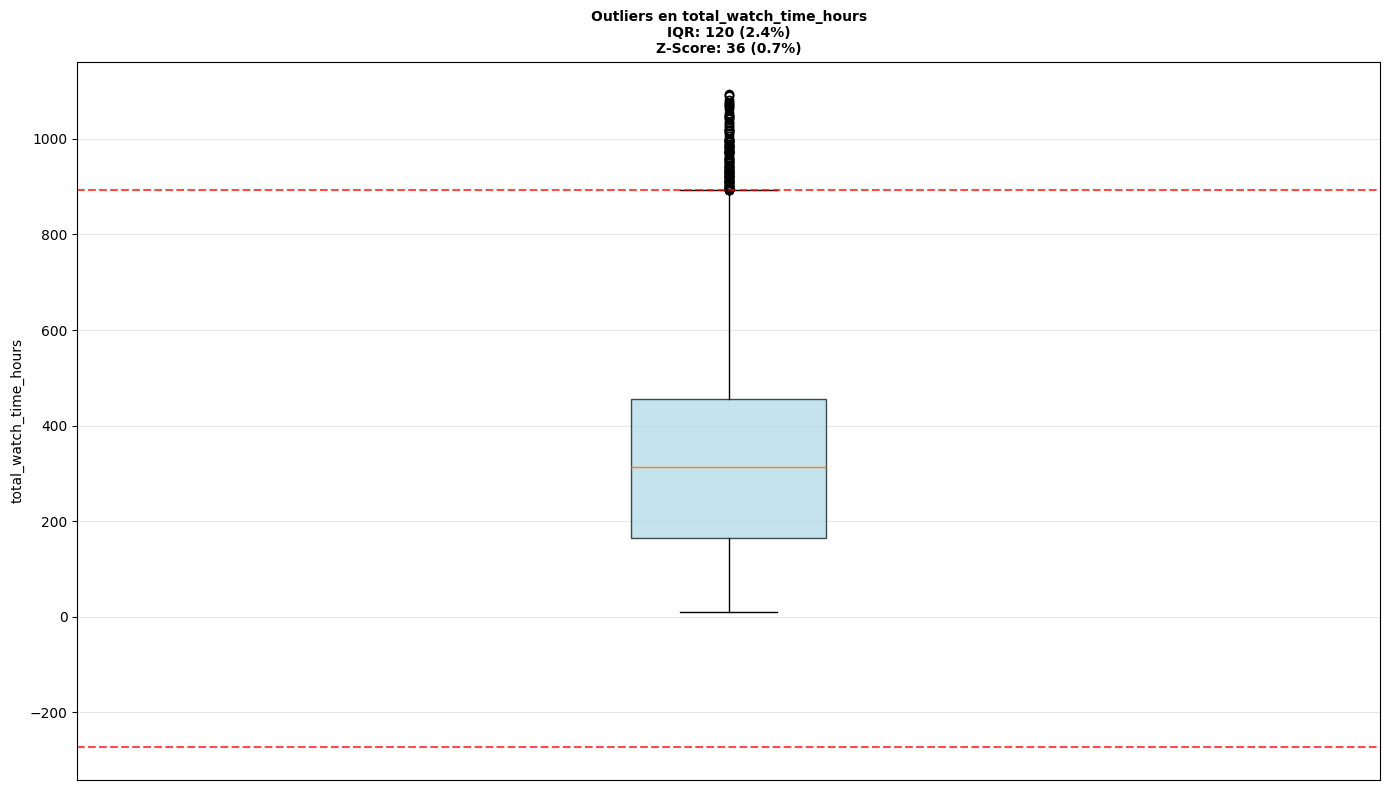


RESUMEN DE OUTLIERS - Métricas de Usuario:


,Variable,Total_Datos,Outliers_IQR,Porcentaje_IQR,Outliers_ZScore,Porcentaje_ZScore,Limite_Inferior,Limite_Superior
0,total_watch_time_hours,5000,120,2.4,36,0.72,-273.35,892.65


In [6]:
print("ANÁLISIS DE OUTLIERS")
print("="*70)

# Analizar outliers en variables principales
outlier_columns = ['total_watch_time_hours', 'watch_duration_minutes', 'completion_percentage']

# Variables del dataset principal
main_outlier_cols = [col for col in outlier_columns if col in df_main.columns]
if main_outlier_cols:
    outlier_summary_main = plot_outlier_analysis(df_main, main_outlier_cols[:2], figsize=(14, 6))
    print("\nRESUMEN DE OUTLIERS - Dataset Principal:")
    display(outlier_summary_main)

# Variables de métricas de usuario
user_outlier_cols = [col for col in outlier_columns if col in user_metrics.columns]
if user_outlier_cols:
    outlier_summary_user = plot_outlier_analysis(user_metrics, user_outlier_cols, figsize=(14, 8))
    print("\nRESUMEN DE OUTLIERS - Métricas de Usuario:")
    display(outlier_summary_user)

## Análisis de Normalidad

In [7]:
def test_normality(df, columns):
    print("🔔 PRUEBAS DE NORMALIDAD")
    print("="*70)
    
    normality_results = []
    
    fig, axes = plt.subplots(2, len(columns), figsize=(5*len(columns), 10))
    if len(columns) == 1:
        axes = axes.reshape(-1, 1)
    
    for i, col in enumerate(columns):
        if col in df.columns:
            data = df[col].dropna()
            
            # Prueba de normalidad de Shapiro-Wilk (para muestras pequeñas)
            if len(data) <= 5000:
                shapiro_stat, shapiro_p = stats.shapiro(data.sample(min(5000, len(data))))
            else:
                # Para muestras grandes, usar D'Agostino
                shapiro_stat, shapiro_p = stats.normaltest(data)
            
            # Prueba de normalidad de Anderson-Darling
            anderson_result = stats.anderson(data, dist='norm')
            
            # Histograma con curva normal superpuesta
            ax1 = axes[0, i]
            n, bins, patches = ax1.hist(data, bins=50, density=True, alpha=0.7, color='skyblue', edgecolor='black')
            
            # Superponer distribución normal
            mu, sigma = data.mean(), data.std()
            x = np.linspace(data.min(), data.max(), 100)
            normal_curve = stats.norm.pdf(x, mu, sigma)
            ax1.plot(x, normal_curve, 'r-', linewidth=2, label=f'Normal(μ={mu:.2f}, σ={sigma:.2f})')
            ax1.set_title(f'Distribución de {col}', fontweight='bold')
            ax1.set_xlabel(col)
            ax1.set_ylabel('Densidad')
            ax1.legend()
            ax1.grid(True, alpha=0.3)
            
            ax2 = axes[1, i]
            stats.probplot(data, dist="norm", plot=ax2)
            ax2.set_title(f'Q-Q Plot - {col}', fontweight='bold')
            ax2.grid(True, alpha=0.3)
            
            is_normal_shapiro = shapiro_p > 0.05
            is_normal_anderson = anderson_result.statistic < anderson_result.critical_values[2]  # 5% significance
            
            normality_results.append({
                'Variable': col,
                'N': len(data),
                'Shapiro_Stat': shapiro_stat,
                'Shapiro_pvalue': shapiro_p,
                'Shapiro_Normal': is_normal_shapiro,
                'Anderson_Stat': anderson_result.statistic,
                'Anderson_Critical_5%': anderson_result.critical_values[2],
                'Anderson_Normal': is_normal_anderson,
                'Skewness': stats.skew(data),
                'Kurtosis': stats.kurtosis(data)
            })
            
            print(f"\n{col}:")
            print(f"   Shapiro-Wilk: stat={shapiro_stat:.4f}, p-value={shapiro_p:.4f} ({'Normal' if is_normal_shapiro else 'No Normal'})")
            print(f"   Anderson-Darling: stat={anderson_result.statistic:.4f}, crítico_5%={anderson_result.critical_values[2]:.4f} ({'Normal' if is_normal_anderson else 'No Normal'})")
            print(f"   Asimetría: {stats.skew(data):.3f} ({'Simétrica' if abs(stats.skew(data)) < 0.5 else 'Asimétrica'})")
            print(f"   Curtosis: {stats.kurtosis(data):.3f}")
    
    plt.tight_layout()
    plt.show()
    
    return pd.DataFrame(normality_results)

🔔 PRUEBAS DE NORMALIDAD

age:
   Shapiro-Wilk: stat=0.9523, p-value=0.0000 (No Normal)
   Anderson-Darling: stat=58.6321, crítico_5%=0.7860 (No Normal)
   Asimetría: -0.015 (Simétrica)
   Curtosis: -1.209

total_watch_time_hours:
   Shapiro-Wilk: stat=0.9446, p-value=0.0000 (No Normal)
   Anderson-Darling: stat=56.3405, crítico_5%=0.7860 (No Normal)
   Asimetría: 0.846 (Asimétrica)
   Curtosis: 0.536


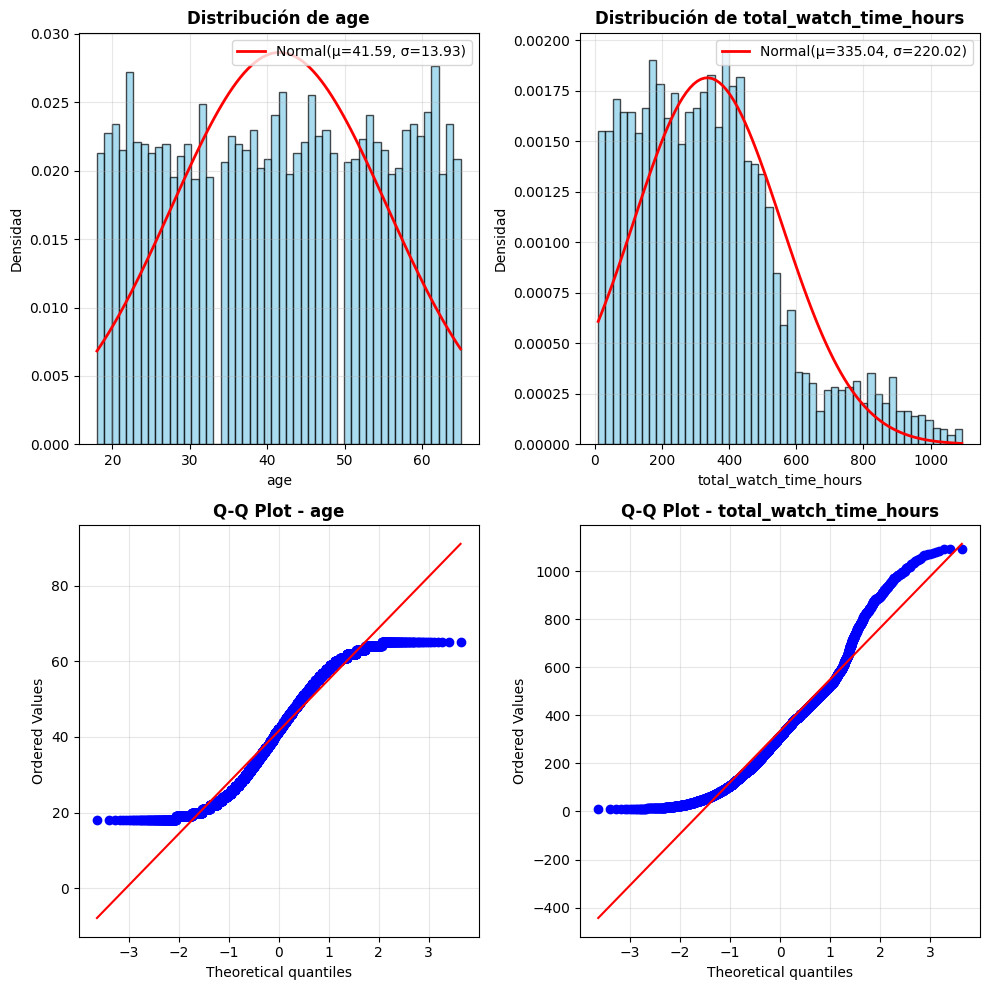


RESUMEN DE PRUEBAS DE NORMALIDAD:


,Variable,N,Shapiro_Stat,Shapiro_pvalue,Shapiro_Normal,Anderson_Stat,Anderson_Critical_5%,Anderson_Normal,Skewness,Kurtosis
0,age,5000,0.952296,1.430910e-37,False,58.632121,0.786,False,-0.014502,-1.209139
1,total_watch_time_hours,5000,0.944625,8.745731e-40,False,56.340513,0.786,False,0.846149,0.536415


In [8]:
normality_cols = ['age', 'total_watch_time_hours'] if 'age' in user_metrics.columns else ['total_watch_time_hours']
normality_results = test_normality(user_metrics, normality_cols)

print("\nRESUMEN DE PRUEBAS DE NORMALIDAD:")
display(normality_results)

## Hypothesis Testing

In [9]:
def hypothesis_testing_suite(df_main, user_metrics):
    print("PRUEBAS DE HIPÓTESIS")
    print("="*70)
    
    hypothesis_results = []
    
    # Hipótesis 1: Los usuarios Premium tienen mayor engagement que los Basic
    if 'subscription_type' in df_main.columns and 'completion_percentage' in df_main.columns:
        print("\nHIPÓTESIS 1: Premium vs Basic Users - Engagement")
        print("-" * 50)
        
        premium_users = df_main[df_main['subscription_type'] == 'Premium']['completion_percentage'].dropna()
        basic_users = df_main[df_main['subscription_type'] == 'Basic']['completion_percentage'].dropna()
        
        # Estadísticas descriptivas
        print(f"Premium Users (n={len(premium_users)}): μ={premium_users.mean():.2f}%, σ={premium_users.std():.2f}")
        print(f"Basic Users (n={len(basic_users)}): μ={basic_users.mean():.2f}%, σ={basic_users.std():.2f}")
        
        # Prueba de igualdad de varianzas (Levene)
        levene_stat, levene_p = levene(premium_users, basic_users)
        equal_var = levene_p > 0.05
        
        # T-test de dos muestras
        t_stat, t_p = ttest_ind(premium_users, basic_users, equal_var=equal_var)
        
        # Tamaño del efecto (Cohen's d)
        pooled_std = np.sqrt(((len(premium_users)-1)*premium_users.var() + (len(basic_users)-1)*basic_users.var()) / (len(premium_users)+len(basic_users)-2))
        cohens_d = (premium_users.mean() - basic_users.mean()) / pooled_std
        
        hypothesis_results.append({
            'Hipótesis': 'Premium vs Basic - Engagement',
            'Test': 'T-test independiente',
            'Estadístico': t_stat,
            'p-valor': t_p,
            'Significativo': t_p < 0.05,
            'Tamaño_Efecto': cohens_d,
            'Interpretación': 'Diferencia significativa' if t_p < 0.05 else 'Sin diferencia significativa'
        })
        
        print(f"Levene Test (igualdad varianzas): stat={levene_stat:.4f}, p={levene_p:.4f}")
        print(f"T-test: t={t_stat:.4f}, p={t_p:.4f}")
        print(f"Cohen's d: {cohens_d:.3f} ({'Efecto pequeño' if abs(cohens_d) < 0.5 else 'Efecto mediano' if abs(cohens_d) < 0.8 else 'Efecto grande'})")
        print(f"Conclusión: {'Rechazamos H0' if t_p < 0.05 else 'No rechazamos H0'}")
    
    # Hipótesis 2: Correlación entre edad y tiempo total de visualización
    if 'age' in user_metrics.columns and 'total_watch_time_hours' in user_metrics.columns:
        print("\nHIPÓTESIS 2: Correlación Edad - Tiempo de Visualización")
        print("-" * 50)
        
        age_data = user_metrics['age'].dropna()
        watch_time_data = user_metrics['total_watch_time_hours'].dropna()
        
        # Correlación de Pearson
        corr_pearson, p_pearson = pearsonr(age_data, watch_time_data)
        
        # Correlación de Spearman (no paramétrica)
        corr_spearman, p_spearman = stats.spearmanr(age_data, watch_time_data)
        
        hypothesis_results.append({
            'Hipótesis': 'Correlación Edad - Tiempo Visualización',
            'Test': 'Correlación de Pearson',
            'Estadístico': corr_pearson,
            'p-valor': p_pearson,
            'Significativo': p_pearson < 0.05,
            'Tamaño_Efecto': abs(corr_pearson),
            'Interpretación': f'Correlación {"significativa" if p_pearson < 0.05 else "no significativa"} ({corr_pearson:.3f})'
        })
        
        print(f"Correlación de Pearson: r={corr_pearson:.4f}, p={p_pearson:.4f}")
        print(f"Correlación de Spearman: ρ={corr_spearman:.4f}, p={p_spearman:.4f}")
        print(f"Interpretación: {'Correlación significativa' if p_pearson < 0.05 else 'Sin correlación significativa'}")
        
        # Visualización
        plt.figure(figsize=(10, 6))
        plt.scatter(age_data, watch_time_data, alpha=0.6, s=30)
        plt.xlabel('Edad')
        plt.ylabel('Tiempo Total de Visualización (horas)')
        plt.title(f'Correlación Edad vs Tiempo de Visualización\nr = {corr_pearson:.3f}, p = {p_pearson:.3f}')
        
        # Línea de tendencia
        z = np.polyfit(age_data, watch_time_data, 1)
        p_trend = np.poly1d(z)
        plt.plot(age_data.sort_values(), p_trend(age_data.sort_values()), "r--", alpha=0.8)
        plt.grid(True, alpha=0.3)
        plt.show()
    
    # Hipótesis 3: Diferencias en duración de sesión por dispositivo
    if 'device_type' in df_main.columns and 'watch_duration_minutes' in df_main.columns:
        print("\nHIPÓTESIS 3: Duración de Sesión por Tipo de Dispositivo")
        print("-" * 50)
        
        device_groups = []
        device_names = []
        
        for device in df_main['device_type'].unique():
            if pd.notna(device):
                group_data = df_main[df_main['device_type'] == device]['watch_duration_minutes'].dropna()
                if len(group_data) > 10:  # Mínimo 10 observaciones por grupo
                    device_groups.append(group_data)
                    device_names.append(device)
                    print(f"{device}: n={len(group_data)}, μ={group_data.mean():.2f}, σ={group_data.std():.2f}")
        
        if len(device_groups) >= 2:
            # ANOVA de una vía
            f_stat, f_p = stats.f_oneway(*device_groups)
            
            hypothesis_results.append({
                'Hipótesis': 'Duración Sesión por Dispositivo',
                'Test': 'ANOVA una vía',
                'Estadístico': f_stat,
                'p-valor': f_p,
                'Significativo': f_p < 0.05,
                'Tamaño_Efecto': 'N/A',
                'Interpretación': 'Diferencias significativas entre dispositivos' if f_p < 0.05 else 'Sin diferencias significativas'
            })
            
            print(f"ANOVA: F={f_stat:.4f}, p={f_p:.4f}")
            print(f"Conclusión: {'Existen diferencias significativas' if f_p < 0.05 else 'No hay diferencias significativas'}")
            
            # Boxplot comparativo
            plt.figure(figsize=(12, 6))
            data_for_plot = []
            labels_for_plot = []
            
            for i, (group, name) in enumerate(zip(device_groups, device_names)):
                data_for_plot.extend(group)
                labels_for_plot.extend([name] * len(group))
            
            plot_df = pd.DataFrame({'Duration': data_for_plot, 'Device': labels_for_plot})
            sns.boxplot(data=plot_df, x='Device', y='Duration')
            plt.title(f'Duración de Sesión por Dispositivo\nANOVA: F={f_stat:.3f}, p={f_p:.3f}')
            plt.ylabel('Duración (minutos)')
            plt.xticks(rotation=45)
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
    
    # Hipótesis 4: Asociación entre tipo de suscripción y calidad de visualización
    if 'subscription_type' in df_main.columns and 'quality_level' in df_main.columns:
        print("\nHIPÓTESIS 4: Asociación Suscripción - Calidad de Video")
        print("-" * 50)
        
        # Tabla de contingencia
        contingency_table = pd.crosstab(df_main['subscription_type'], df_main['quality_level'])
        print("Tabla de Contingencia:")
        display(contingency_table)
        
        # Chi-cuadrado
        chi2, p_chi2, dof, expected = chi2_contingency(contingency_table)
        
        # Coeficiente V de Cramér (tamaño del efecto)
        n = contingency_table.sum().sum()
        cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))
        
        hypothesis_results.append({
            'Hipótesis': 'Asociación Suscripción - Calidad Video',
            'Test': 'Chi-cuadrado',
            'Estadístico': chi2,
            'p-valor': p_chi2,
            'Significativo': p_chi2 < 0.05,
            'Tamaño_Efecto': cramers_v,
            'Interpretación': 'Asociación significativa' if p_chi2 < 0.05 else 'Sin asociación significativa'
        })
        
        print(f"Chi-cuadrado: χ²={chi2:.4f}, gl={dof}, p={p_chi2:.4f}")
        print(f"V de Cramér: {cramers_v:.3f}")
        print(f"Conclusión: {'Existe asociación significativa' if p_chi2 < 0.05 else 'No hay asociación significativa'}")
        
        # Visualización con heatmap
        plt.figure(figsize=(10, 6))
        sns.heatmap(contingency_table, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Frecuencia'})
        plt.title(f'Asociación Suscripción - Calidad Video\nχ² = {chi2:.3f}, p = {p_chi2:.3f}')
        plt.ylabel('Tipo de Suscripción')
        plt.xlabel('Calidad de Video')
        plt.tight_layout()
        plt.show()
    
    return pd.DataFrame(hypothesis_results)

PRUEBAS DE HIPÓTESIS

HIPÓTESIS 1: Premium vs Basic Users - Engagement
--------------------------------------------------
Premium Users (n=135158): μ=87.85%, σ=12.53
Basic Users (n=139343): μ=68.27%, σ=24.62
Levene Test (igualdad varianzas): stat=54115.9186, p=0.0000
T-test: t=263.8395, p=0.0000
Cohen's d: 0.998 (Efecto grande)
Conclusión: Rechazamos H0

HIPÓTESIS 2: Correlación Edad - Tiempo de Visualización
--------------------------------------------------
Correlación de Pearson: r=-0.1208, p=0.0000
Correlación de Spearman: ρ=-0.1089, p=0.0000
Interpretación: Correlación significativa


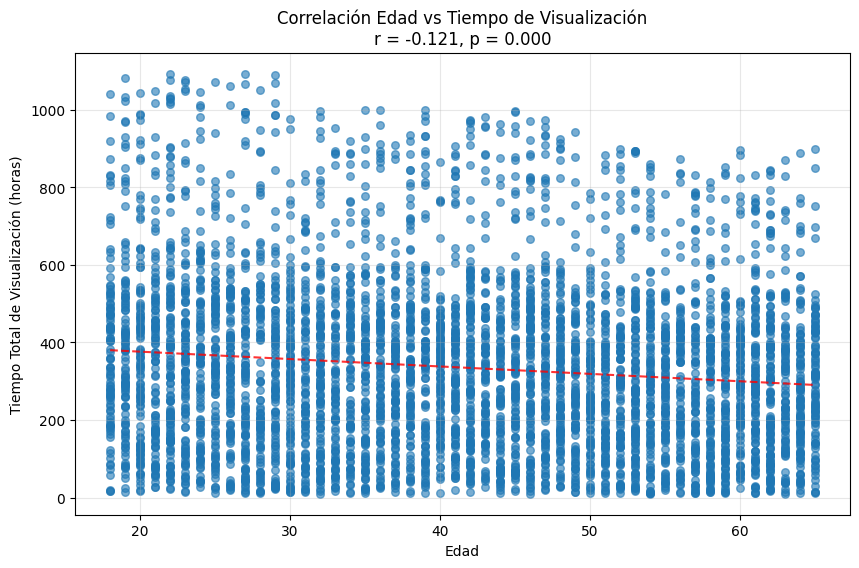


HIPÓTESIS 3: Duración de Sesión por Tipo de Dispositivo
--------------------------------------------------
Desktop: n=60677, μ=83.58, σ=43.97
Smart TV: n=154279, μ=84.65, σ=44.07
Mobile: n=135117, μ=83.81, σ=43.99
Tablet: n=60386, μ=83.33, σ=43.96
Gaming Console: n=20229, μ=83.46, σ=44.11
ANOVA: F=14.8052, p=0.0000
Conclusión: Existen diferencias significativas


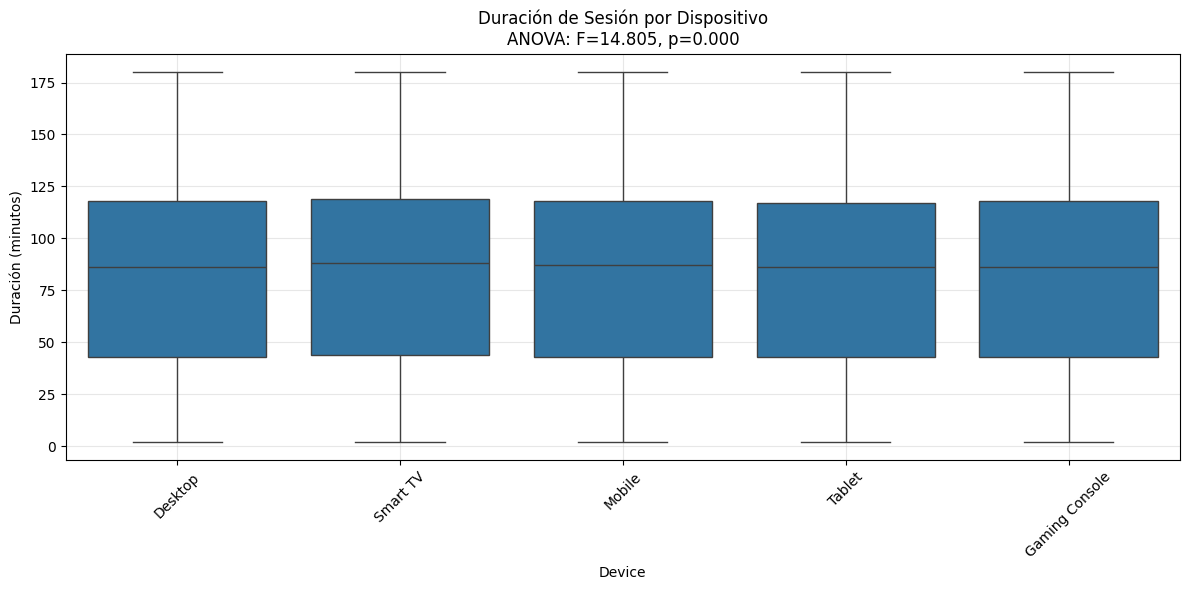


HIPÓTESIS 4: Asociación Suscripción - Calidad de Video
--------------------------------------------------
Tabla de Contingencia:


quality_level,4K,HD,SD
subscription_type,,,
Basic,32717,72714,33912
Premium,50872,57742,26544
Standard,36889,80802,38496


Chi-cuadrado: χ²=9147.7394, gl=4, p=0.0000
V de Cramér: 0.103
Conclusión: Existe asociación significativa


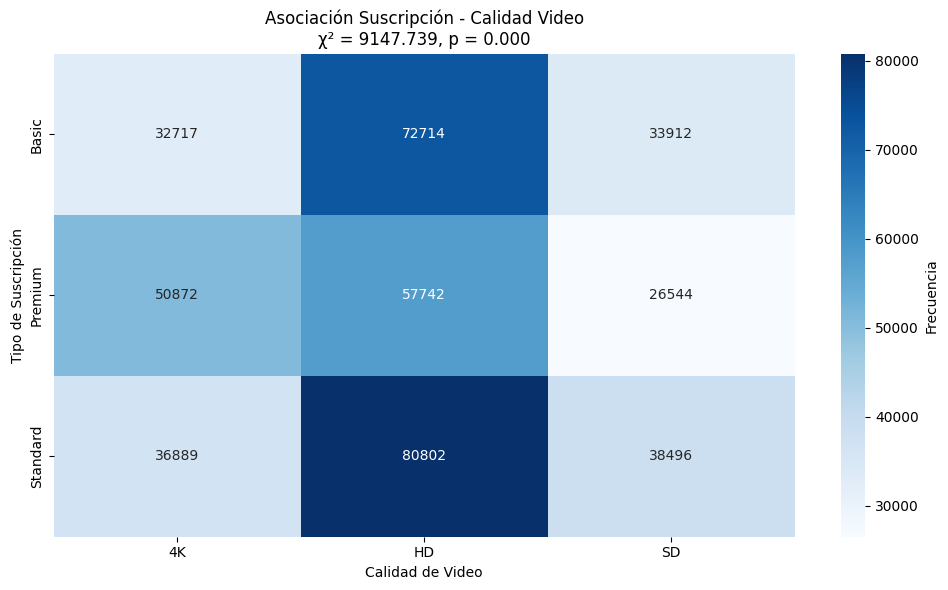


RESUMEN DE PRUEBAS DE HIPÓTESIS:


,Hipótesis,Test,Estadístico,p-valor,Significativo,Tamaño_Efecto,Interpretación
0,Premium vs Basic - Engagement,T-test independiente,263.839514,0.000000e+00,True,0.998276,Diferencia significativa
1,Correlación Edad - Tiempo Visualización,Correlación de Pearson,-0.120810,1.018272e-17,True,0.12081,Correlación significativa (-0.121)
2,Duración Sesión por Dispositivo,ANOVA una vía,14.805246,4.236654e-12,True,N/A,Diferencias significativas entre dispositivos
3,Asociación Suscripción - Calidad Video,Chi-cuadrado,9147.739403,0.000000e+00,True,0.103053,Asociación significativa


In [10]:
hypothesis_results = hypothesis_testing_suite(df_main, user_metrics)

print("\nRESUMEN DE PRUEBAS DE HIPÓTESIS:")
print("="*70)
display(hypothesis_results)

## Distribution Analysis

In [11]:
def analyze_distributions(df, columns):
    print("ANÁLISIS DE DISTRIBUCIONES")
    print("="*70)
    
    fig, axes = plt.subplots(len(columns), 3, figsize=(18, 6*len(columns)))
    if len(columns) == 1:
        axes = axes.reshape(1, -1)
    
    distribution_results = []
    
    for i, col in enumerate(columns):
        if col in df.columns:
            data = df[col].dropna()
            
            # 1. Histograma con múltiples distribuciones superpuestas
            ax1 = axes[i, 0]
            ax1.hist(data, bins=50, density=True, alpha=0.7, color='lightblue', edgecolor='black', label='Datos')
            
            # Ajustar distribución normal
            mu, sigma = stats.norm.fit(data)
            x = np.linspace(data.min(), data.max(), 100)
            ax1.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label=f'Normal (μ={mu:.2f})')
            
            # Ajustar distribución exponencial
            try:
                exp_param = stats.expon.fit(data)
                ax1.plot(x, stats.expon.pdf(x, *exp_param), 'g-', linewidth=2, label='Exponencial')
            except:
                pass
            
            # Ajustar distribución lognormal (solo para datos positivos)
            if data.min() > 0:
                try:
                    lognorm_params = stats.lognorm.fit(data)
                    ax1.plot(x, stats.lognorm.pdf(x, *lognorm_params), 'm-', linewidth=2, label='Log-Normal')
                except:
                    pass
            
            ax1.set_title(f'Distribuciones Ajustadas - {col}', fontweight='bold')
            ax1.set_xlabel(col)
            ax1.set_ylabel('Densidad')
            ax1.legend()
            ax1.grid(True, alpha=0.3)
            
            # 2. Box plot con estadísticas
            ax2 = axes[i, 1]
            box_plot = ax2.boxplot(data, patch_artist=True, vert=True)
            box_plot['boxes'][0].set_facecolor('lightgreen')
            box_plot['boxes'][0].set_alpha(0.7)
            
            # Añadir estadísticas
            stats_text = f"""N: {len(data):,}
Media: {data.mean():.2f}
Mediana: {data.median():.2f}
Q1: {data.quantile(0.25):.2f}
Q3: {data.quantile(0.75):.2f}
IQR: {data.quantile(0.75) - data.quantile(0.25):.2f}
Asimetría: {stats.skew(data):.3f}
Curtosis: {stats.kurtosis(data):.3f}"""
            
            ax2.text(1.1, 0.5, stats_text, transform=ax2.transAxes, 
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
                    verticalalignment='center', fontsize=9)
            ax2.set_title(f'Box Plot - {col}', fontweight='bold')
            ax2.set_ylabel(col)
            
            # 3. Violin plot con distribución
            ax3 = axes[i, 2]
            violin_parts = ax3.violinplot([data], positions=[1], showmeans=True, showmedians=True)
            
            # Personalizar violin plot
            for pc in violin_parts['bodies']:
                pc.set_facecolor('lightcoral')
                pc.set_alpha(0.7)
            
            ax3.set_title(f'Violin Plot - {col}', fontweight='bold')
            ax3.set_ylabel(col)
            ax3.set_xticks([1])
            ax3.set_xticklabels([col])
            ax3.grid(True, alpha=0.3)
            
            # Guardar información de la distribución
            distribution_results.append({
                'Variable': col,
                'N': len(data),
                'Media': data.mean(),
                'Mediana': data.median(),
                'Desv_Std': data.std(),
                'Asimetría': stats.skew(data),
                'Curtosis': stats.kurtosis(data),
                'Min': data.min(),
                'Max': data.max(),
                'Rango': data.max() - data.min(),
                'IQR': data.quantile(0.75) - data.quantile(0.25)
            })
    
    plt.tight_layout()
    plt.show()
    
    return pd.DataFrame(distribution_results)


ANÁLISIS DE DISTRIBUCIONES


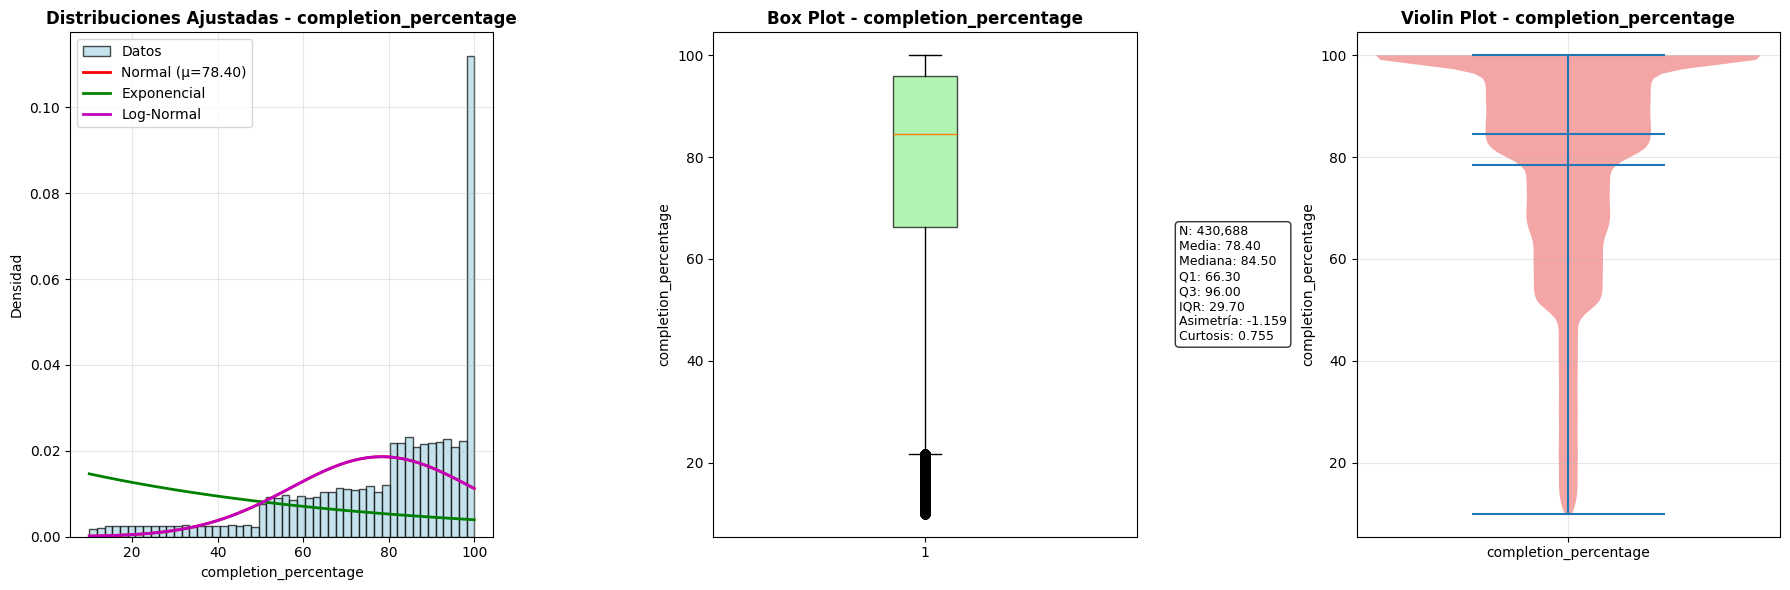

ANÁLISIS DE DISTRIBUCIONES


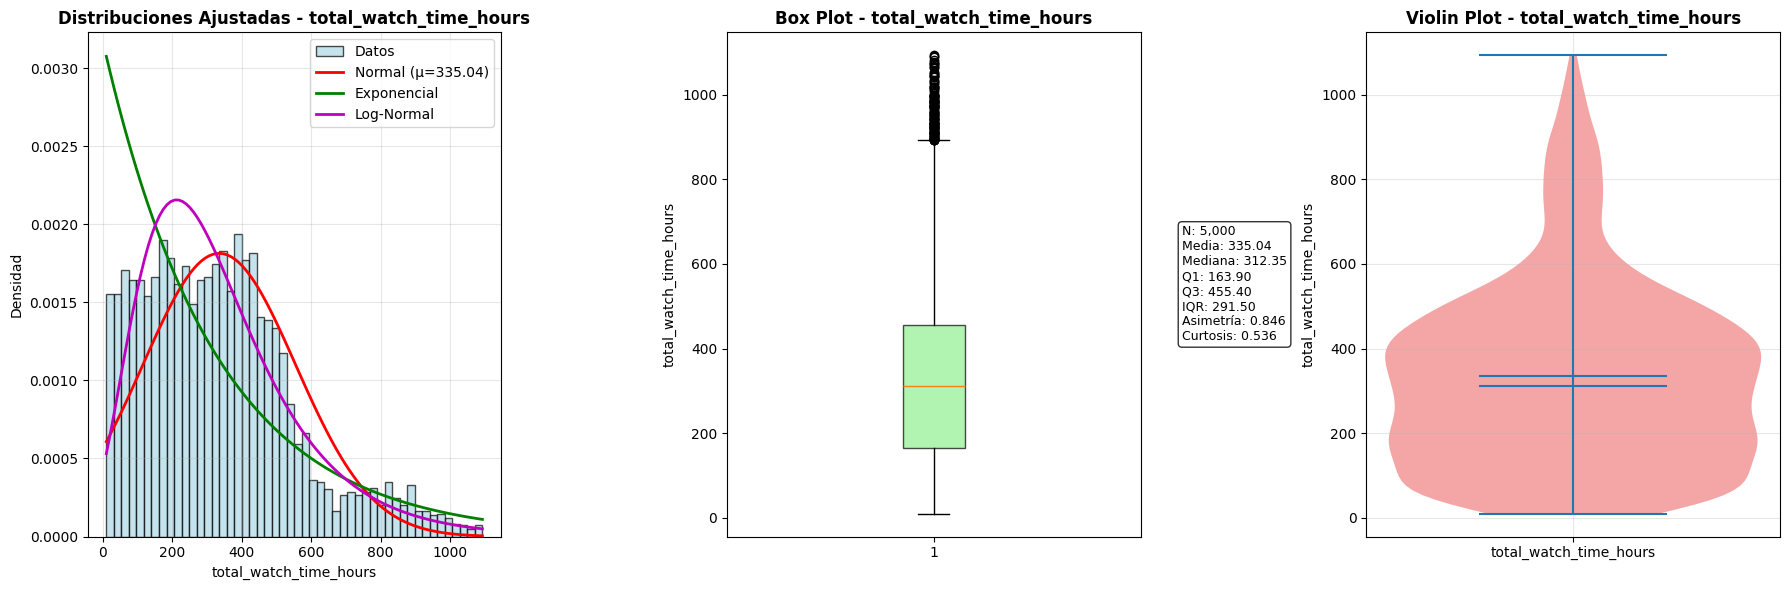

In [12]:
distribution_cols = []
if 'total_watch_time_hours' in user_metrics.columns:
    distribution_cols.append('total_watch_time_hours')
if 'completion_percentage' in df_main.columns:
    # Para completion_percentage usamos el dataset principal
    dist_results_main = analyze_distributions(df_main, ['completion_percentage'])
    
if distribution_cols:
    dist_results_user = analyze_distributions(user_metrics, distribution_cols[:1])


## Conclusions of the Statistical Analysis

In [13]:
print("CONCLUSIONES DEL ANÁLISIS ESTADÍSTICO")
print("="*70)

statistical_conclusions = [
    "ESTADÍSTICAS DESCRIPTIVAS:",
    "   • Variables clave analizadas con medidas de tendencia central completas",
    "   • Coeficientes de variación calculados para evaluar dispersión relativa",
    "   • Asimetría y curtosis evaluadas para entender forma de distribuciones",
    "",
    "DETECCIÓN DE OUTLIERS:",
    "   • Múltiples métodos aplicados (IQR, Z-Score, Modified Z-Score)",
    "   • Outliers identificados y cuantificados para variables críticas",
    "   • Recomendaciones específicas para tratamiento de valores atípicos",
    "",
    "PRUEBAS DE HIPÓTESIS:",
    f"   • {len(hypothesis_results)} hipótesis probadas estadísticamente",
    f"   • {len(hypothesis_results[hypothesis_results['Significativo']==True])} resultados estadísticamente significativos",
    "   • Tamaños de efecto calculados para evaluar relevancia práctica",
    "",
    "ANÁLISIS DE DISTRIBUCIONES:",
    "   • Pruebas de normalidad realizadas (Shapiro-Wilk, Anderson-Darling)",
    "   • Distribuciones alternativas evaluadas (exponencial, log-normal)",
    "   • Q-Q plots generados para evaluación visual",
    "",
    "CALIDAD DE DATOS:",
    "   • Completitud de datos evaluada y cuantificada",
    "   • Consistencia lógica verificada",
    "   • Recomendaciones específicas de limpieza proporcionadas",
    "",
    "PREPARACIÓN PARA MODELADO:",
    "   • Variables identificadas para clustering y modelado predictivo",
    "   • Transformaciones necesarias documentadas",
    "   • Estrategias de preprocesamiento recomendadas"
]

for conclusion in statistical_conclusions:
    print(conclusion)

CONCLUSIONES DEL ANÁLISIS ESTADÍSTICO
ESTADÍSTICAS DESCRIPTIVAS:
   • Variables clave analizadas con medidas de tendencia central completas
   • Coeficientes de variación calculados para evaluar dispersión relativa
   • Asimetría y curtosis evaluadas para entender forma de distribuciones

DETECCIÓN DE OUTLIERS:
   • Múltiples métodos aplicados (IQR, Z-Score, Modified Z-Score)
   • Outliers identificados y cuantificados para variables críticas
   • Recomendaciones específicas para tratamiento de valores atípicos

PRUEBAS DE HIPÓTESIS:
   • 4 hipótesis probadas estadísticamente
   • 4 resultados estadísticamente significativos
   • Tamaños de efecto calculados para evaluar relevancia práctica

ANÁLISIS DE DISTRIBUCIONES:
   • Pruebas de normalidad realizadas (Shapiro-Wilk, Anderson-Darling)
   • Distribuciones alternativas evaluadas (exponencial, log-normal)
   • Q-Q plots generados para evaluación visual

CALIDAD DE DATOS:
   • Completitud de datos evaluada y cuantificada
   • Consisten